# FAQ Notebook for Public Library Data

## What percentage of the US population is served by each of the budget categories of public libraries?

First, let's define our categories. The lowest budget categories are consolidated into one.

In [1]:
categories = [
  { "minValue": 30000000, "label": 'G. $30M+' },
  { "minValue": 10000000, "maxValue": 30000000, "label": 'F. $10M - $30M' },
  { "minValue": 5000000, "maxValue": 10000000, "label": 'E. $5M - $10M' },
  { "minValue": 1000000, "maxValue": 5000000, "label": 'D. $1M - $5M' },
  { "minValue": 400000, "maxValue": 1000000, "label": 'C. $400K - $1M' },
  { "minValue": 200000, "maxValue": 400000, "label": 'B. $200K - $400K' },
  { "minValue": 0, "maxValue": 200000, "label": 'A. Below $200K' }
]

Next we will read the public libary data.

In [2]:
import pandas as pd
from helpers import *

lib_df = pd.read_csv("data/PLS_FY22_AE_pud22i.csv", encoding="latin-1")
lib_count = lib_df.shape[0]
print(f"Found {lib_count:,} entries from the public library survey")

Found 9,248 entries from the public library survey


Next we will categorize each library based on their budget value, then display the frequency/percent for each category

In [3]:
def get_category(lib, categories):
  category = "None"
  for cat in categories:
    if "minValue" in cat and "maxValue" in cat and lib["TOTINCM"] >= cat["minValue"] and lib["TOTINCM"] < cat["maxValue"]:
      category = cat["label"]
      break
    elif "minValue" in cat and lib["TOTINCM"] >= cat["minValue"]:
      category = cat["label"]
      break
  return category
lib_df["BUDGET_CATEGORY"] = lib_df.apply(lambda row: get_category(row, categories), axis=1)
frequencies = lib_df["BUDGET_CATEGORY"].value_counts(sort=False)
stats_df = pd.DataFrame({"Group": frequencies.index, "Libraries": frequencies.values})
stats_df = stats_df.sort_values(by=["Group"]).reset_index(drop=True)
stats_df["% libraries"] = stats_df.apply(lambda row: row["Libraries"] / lib_count * 100, axis=1)
stats_df.style.format(precision=2, thousands=",")
# category_frequencies.plot.pie(y=category_frequencies.index, autopct='%1.1f%%')

,Group,Libraries,% libraries
0,A. Below $200K,"3,839",41.51
1,B. $200K - $400K,"1,373",14.85
2,C. $400K - $1M,"1,642",17.76
3,D. $1M - $5M,"1,772",19.16
4,E. $5M - $10M,305,3.30
5,F. $10M - $30M,162,1.75
6,G. $30M+,83,0.90
7,None,72,0.78


Next we will calculate and display the population served for each budget category

In [4]:
total_population_served = lib_df[lib_df["POPU_LSA"] > 0]["POPU_LSA"].sum()
print(f"Total population served by libraries in this dataset: {total_population_served:,}")

def get_population_served(df, group):
  return df[(df["POPU_LSA"] > 0) & (df["BUDGET_CATEGORY"] == group)]["POPU_LSA"].sum()

stats_df["Population"] = stats_df.apply(lambda row: get_population_served(lib_df, row["Group"]), axis=1)
stats_df["% population"] = stats_df.apply(lambda row: row["Population"] / total_population_served * 100, axis=1)
stats_df.style.format(precision=2, thousands=",")


Total population served by libraries in this dataset: 334,210,711


,Group,Libraries,% libraries,Population,% population
0,A. Below $200K,"3,839",41.51,"11,664,005",3.49
1,B. $200K - $400K,"1,373",14.85,"13,107,111",3.92
2,C. $400K - $1M,"1,642",17.76,"28,479,207",8.52
3,D. $1M - $5M,"1,772",19.16,"90,785,270",27.16
4,E. $5M - $10M,305,3.30,"42,840,040",12.82
5,F. $10M - $30M,162,1.75,"50,187,204",15.02
6,G. $30M+,83,0.90,"94,232,698",28.20
7,None,72,0.78,"2,915,176",0.87


As you can see, the **libraries with the largest budgets ($30M+) account for less than 1% of all libraries but serve the largest percent of the population at 28.2%**.  Just behind that group are ibraries with a budget between $1 and $5M, which serve 27.16% of the population.

Now let's look at library visits per capita for each category

In [5]:
lib_df = calculate_per(lib_df, "VISITS", "POPU_LSA", "VISITS_PER")
stats_df["Visits per capita"] = stats_df.apply(lambda row: lib_df[lib_df["BUDGET_CATEGORY"] == row["Group"]]["VISITS_PER"].median(), axis=1)
stats_df.style.format(precision=2, thousands=",")

,Group,Libraries,% libraries,Population,% population,Visits per capita
0,A. Below $200K,"3,839",41.51,"11,664,005",3.49,2.27
1,B. $200K - $400K,"1,373",14.85,"13,107,111",3.92,2.46
2,C. $400K - $1M,"1,642",17.76,"28,479,207",8.52,2.73
3,D. $1M - $5M,"1,772",19.16,"90,785,270",27.16,2.44
4,E. $5M - $10M,305,3.30,"42,840,040",12.82,2.28
5,F. $10M - $30M,162,1.75,"50,187,204",15.02,2.16
6,G. $30M+,83,0.90,"94,232,698",28.20,2.10
7,None,72,0.78,"2,915,176",0.87,0.00


Visits per capita doesn't vary widely between categories

## Can you create a profile of the Detroit public library with a cohort of similar libraries? Like, library systems servins X-sized urban populations, with X diversity factors?

Yes, I put it in its [own notebook here](https://github.com/beefoo/public-library-survey/blob/main/similarity.ipynb).

## Is there some sort of wealth + diversity of population X library system size scale?

First, let's load in Census data for median household income, race, and ethnicity, and merge it with our data using zipcodes.

In [6]:
income_df = pd.read_csv("data/ACSDT5Y2023.B19013-Data-Houshold-Income-By-Zipcode.csv", skiprows=[1])
print(f"Found {income_df.shape[0]:,} entries from the Census median household income dataset")

race_df = pd.read_csv("data/ACSDT5Y2023.B02001-Data-Race-By-Zipcode.csv", skiprows=[1])
print(f"Found {race_df.shape[0]:,} entries from the Census race dataset")

ethnicity_df = pd.read_csv("data/ACSDT5Y2023.B03003-Data-Hispanic-By-Zipcode.csv", skiprows=[1])
print(f"Found {ethnicity_df.shape[0]:,} entries from the Census ethnicity (Hispanic or Latino) dataset")

# Create a new column "GEO_ID" that will match the GEO_ID (zipcode) in the Census data
lib_df["GEO_ID"] = lib_df.apply(
    lambda row: f"860Z200US{str(row['ZIP']).zfill(5)}", axis=1
)
lib_df = pd.merge(lib_df, income_df, on="GEO_ID", how="left")
lib_df = pd.merge(lib_df, race_df, on="GEO_ID", how="left")
lib_df = pd.merge(lib_df, ethnicity_df, on="GEO_ID", how="left")
print(f"{lib_df.shape[0]:,} entries after merging")

Found 33,772 entries from the Census median household income dataset
Found 33,772 entries from the Census race dataset
Found 33,772 entries from the Census ethnicity (Hispanic or Latino) dataset
9,248 entries after merging


Next, we will clean up income data and create a new column that tells us the percent POC (including non-white Hispanic/Latino)

In [7]:
# Parse income
lib_df["MEDIAN_INCOME"] = lib_df.apply(
    lambda row: parse_int(row["B19013_001E"]), axis=1
)
print(f"The median median houshold income is ${lib_df['MEDIAN_INCOME'].median():,}")

lib_df = calculate_percent_pos(lib_df)
print(f"The median percent person of color or Hispanic/Latino per library is {lib_df['PERC_POC_OR_HISPANIC'].median():,}%")

The median median houshold income is $70,078.5
The median percent person of color or Hispanic/Latino per library is 7.605%


Let's plot median household income with library size (budget)

Text(0, 0.5, 'Median household income')

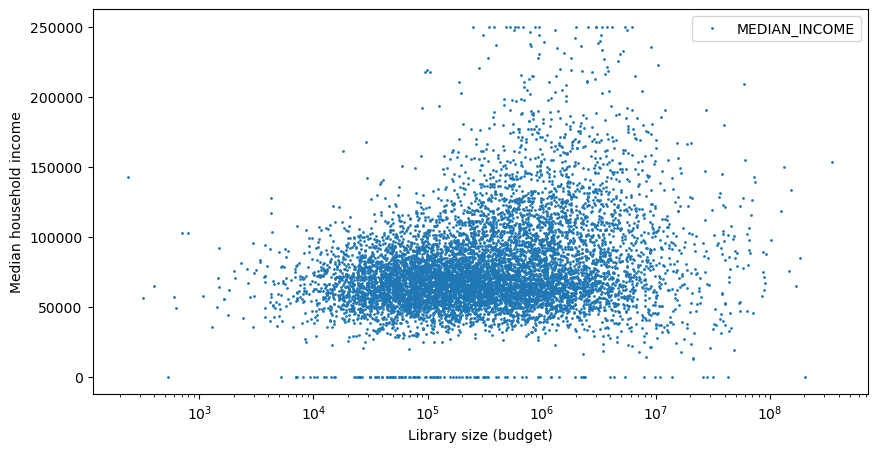

In [8]:
ax = lib_df.plot(x="TOTINCM", y="MEDIAN_INCOME", style='o', markersize=1, figsize=(10, 5))
ax.set_xlabel("Library size (budget)")
ax.set_xscale('log')
ax.set_ylabel("Median household income")

And let's look at the median median household income for each library category

In [9]:
stats_df["Median income"] = stats_df.apply(lambda row: lib_df[lib_df["BUDGET_CATEGORY"] == row["Group"]]["MEDIAN_INCOME"].median(), axis=1)
stats_df.style.format(precision=2, thousands=",")

,Group,Libraries,% libraries,Population,% population,Visits per capita,Median income
0,A. Below $200K,"3,839",41.51,"11,664,005",3.49,2.27,"66,250.00"
1,B. $200K - $400K,"1,373",14.85,"13,107,111",3.92,2.46,"70,348.00"
2,C. $400K - $1M,"1,642",17.76,"28,479,207",8.52,2.73,"73,326.00"
3,D. $1M - $5M,"1,772",19.16,"90,785,270",27.16,2.44,"77,746.00"
4,E. $5M - $10M,305,3.30,"42,840,040",12.82,2.28,"82,365.00"
5,F. $10M - $30M,162,1.75,"50,187,204",15.02,2.16,"74,729.50"
6,G. $30M+,83,0.90,"94,232,698",28.20,2.10,"85,436.00"
7,None,72,0.78,"2,915,176",0.87,0.00,"27,049.00"


And plot % POC with library size (budget)

Text(0, 0.5, 'Percent POC')

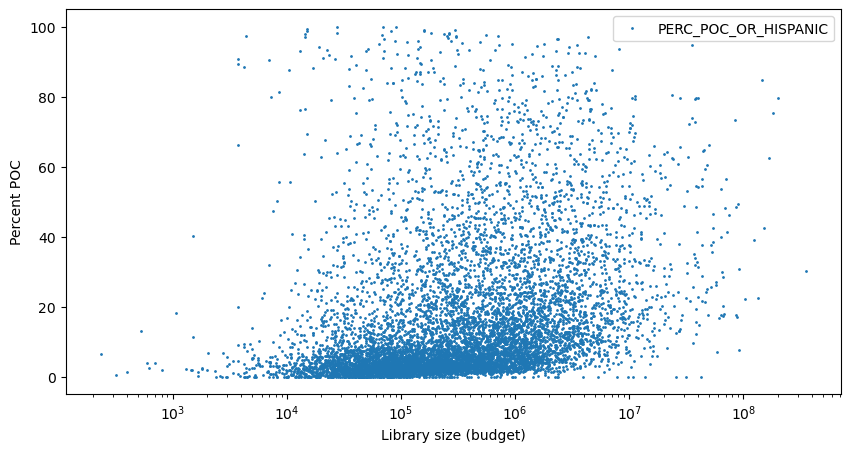

In [10]:
ax = lib_df.plot(x="TOTINCM", y="PERC_POC_OR_HISPANIC", style='o', markersize=1, figsize=(10, 5))
ax.set_xlabel("Library size (budget)")
ax.set_xscale('log')
ax.set_ylabel("Percent POC")

And let's look at the % POC for each library group

In [11]:
stats_df["% POC"] = stats_df.apply(lambda row: lib_df[lib_df["BUDGET_CATEGORY"] == row["Group"]]["PERC_POC_OR_HISPANIC"].mean(), axis=1)
stats_df.style.format(precision=2, thousands=",")

,Group,Libraries,% libraries,Population,% population,Visits per capita,Median income,% POC
0,A. Below $200K,"3,839",41.51,"11,664,005",3.49,2.27,"66,250.00",10.56
1,B. $200K - $400K,"1,373",14.85,"13,107,111",3.92,2.46,"70,348.00",13.73
2,C. $400K - $1M,"1,642",17.76,"28,479,207",8.52,2.73,"73,326.00",17.07
3,D. $1M - $5M,"1,772",19.16,"90,785,270",27.16,2.44,"77,746.00",23.43
4,E. $5M - $10M,305,3.30,"42,840,040",12.82,2.28,"82,365.00",28.24
5,F. $10M - $30M,162,1.75,"50,187,204",15.02,2.16,"74,729.50",33.71
6,G. $30M+,83,0.90,"94,232,698",28.20,2.10,"85,436.00",39.55
7,None,72,0.78,"2,915,176",0.87,0.00,"27,049.00",71.96


## Breakdown of program attendance by population?

Before we look at attendance, let's take a look at on-site programs offered for each Library category relative to the size of the population they are serving (i.e. per capita)

In [15]:
lib_df = calculate_per(lib_df, "ONPRO", "POPU_LSA", "ONPRO_PER")
stats_df["Onsite programs (median)"] = stats_df.apply(lambda row: lib_df[lib_df["BUDGET_CATEGORY"] == row["Group"]]["ONPRO"].median(), axis=1)
stats_df["Onsite programs per capita"] = stats_df.apply(lambda row: lib_df[lib_df["BUDGET_CATEGORY"] == row["Group"]]["ONPRO_PER"].median(), axis=1)
stats_df[["Group", "Libraries", "Onsite programs (median)", "Onsite programs per capita"]].style.format(precision=3, thousands=",")

,Group,Libraries,Onsite programs (median),Onsite programs per capita
0,A. Below $200K,"3,839",36.000,0.017
1,B. $200K - $400K,"1,373",117.000,0.016
2,C. $400K - $1M,"1,642",192.000,0.014
3,D. $1M - $5M,"1,772",349.000,0.009
4,E. $5M - $10M,305,633.000,0.005
5,F. $10M - $30M,162,"1,303.500",0.004
6,G. $30M+,83,"2,931.000",0.003
7,None,72,-1.000,0.000


Now let's look at attendance per program for each library category

In [16]:
lib_df = calculate_per(lib_df, "ONATTEN", "ONPRO", "ATTEN_PER")
stats_df["Attendance per program"] = stats_df.apply(lambda row: lib_df[lib_df["BUDGET_CATEGORY"] == row["Group"]]["ATTEN_PER"].median(), axis=1)
stats_df[["Group", "Libraries", "Onsite programs (median)", "Onsite programs per capita", "Attendance per program"]].style.format(precision=3, thousands=",")

,Group,Libraries,Onsite programs (median),Onsite programs per capita,Attendance per program
0,A. Below $200K,"3,839",36.000,0.017,9.611
1,B. $200K - $400K,"1,373",117.000,0.016,12.466
2,C. $400K - $1M,"1,642",192.000,0.014,14.608
3,D. $1M - $5M,"1,772",349.000,0.009,16.483
4,E. $5M - $10M,305,633.000,0.005,18.196
5,F. $10M - $30M,162,"1,303.500",0.004,16.875
6,G. $30M+,83,"2,931.000",0.003,18.072
7,None,72,-1.000,0.000,0.000


## Which libraries in each category have a relatively high number and attendance of programs?

Starting with the largest group ($30M+), the libraries with the highest attendance for on-site programs

In [23]:
group1 = lib_df[lib_df["BUDGET_CATEGORY"] == "G. $30M+"].sort_values(by=["ATTEN_PER"], ascending=False)
group1[["LIBNAME", "CITY", "STABR", "ONPRO", "ONATTEN", "ATTEN_PER"]].head(10)

,LIBNAME,CITY,STABR,ONPRO,ONATTEN,ATTEN_PER
2770,JOHNSON COUNTY LIBRARY,OVERLAND PARK,KS,582,33708,57.918
7493,RICHLAND COUNTY PUBLIC LIBRARY,COLUMBIA,SC,1210,67926,56.137
561,SAN JOSE PUBLIC LIBRARY,SAN JOSE,CA,2283,119527,52.355
8736,SEATTLE PUBLIC LIBRARY,SEATTLE,WA,240,9479,39.496
4361,SAINT LOUIS COUNTY LIBRARY,ST. LOUIS,MO,809,31782,39.286
3535,MONTGOMERY COUNTY PUBLIC LIBRARIES,ROCKVILLE,MD,928,33784,36.405
3521,ANNE ARUNDEL COUNTY PUBLIC LIBRARY,ANNAPOLIS,MD,4413,138025,31.277
4660,CHARLOTTE MECKLENBURG LIBRARY,CHARLOTTE,NC,2010,61436,30.565
560,SAN FRANCISCO PUBLIC LIBRARY,SAN FRANCISCO,CA,1046,31789,30.391
566,SAN MATEO COUNTY LIBRARIES,SAN MATEO,CA,2362,68634,29.058


And the next group $10M - $30M, filtering out libraries with less than 100 programs

In [24]:
group2 = lib_df[(lib_df["BUDGET_CATEGORY"] == "F. $10M - $30M") & (lib_df["ONPRO"] >= 100)].sort_values(by=["ATTEN_PER"], ascending=False)
group2[["LIBNAME", "CITY", "STABR", "ONPRO", "ONATTEN", "ATTEN_PER"]].head(10)

,LIBNAME,CITY,STABR,ONPRO,ONATTEN,ATTEN_PER
3802,ANN ARBOR DISTRICT LIBRARY,ANN ARBOR,MI,422,30589,72.486
460,BERKELEY PUBLIC LIBRARY,BERKELEY,CA,166,8849,53.307
1087,DEKALB COUNTY PUBLIC LIBRARY,DECATUR,GA,1054,48136,45.670
7480,GREENVILLE COUNTY LIBRARY SYSTEM,GREENVILLE,SC,916,35605,38.870
3530,FREDERICK COUNTY PUBLIC LIBRARIES,FREDERICK,MD,994,38270,38.501
2135,NAPERVILLE PUBLIC LIBRARY,NAPERVILLE,IL,998,37584,37.659
6561,MEDINA COUNTY DISTRICT LIBRARY,MEDINA,OH,2737,98711,36.065
8014,FORT BEND COUNTY LIBRARIES,RICHMOND,TX,1895,65711,34.676
8399,WEBER COUNTY LIBRARY SYSTEM,ROY,UT,3460,116303,33.614
8379,SALT LAKE CITY PUBLIC LIBRARY SYSTEM,SALT LAKE CITY,UT,350,11265,32.186


And the next group $5M to $10M, filtering out libraries with less than 100 programs

In [25]:
group3 = lib_df[(lib_df["BUDGET_CATEGORY"] == "E. $5M - $10M") & (lib_df["ONPRO"] >= 100)].sort_values(by=["ATTEN_PER"], ascending=False)
group3[["LIBNAME", "CITY", "STABR", "ONPRO", "ONATTEN", "ATTEN_PER"]].head(10)

,LIBNAME,CITY,STABR,ONPRO,ONATTEN,ATTEN_PER
994,MARION COUNTY PUBLIC LIBRARY SYSTEM,OCALA,FL,131,16411,125.275
6465,WASHINGTON-CENTERVILLE PUBLIC LIBRARY,CENTERVILLE,OH,768,84166,109.591
522,MOUNTAIN VIEW PUBLIC LIBRARY,MOUNTAIN VIEW,CA,104,7019,67.490
3955,JACKSON DISTRICT LIBRARY,JACKSON,MI,417,26639,63.882
6287,HALF HOLLOW HILLS COMMUNITY PUBLIC LIBRARY,DIX HILLS,NY,851,50609,59.470
526,NEWPORT BEACH PUBLIC LIBRARY,NEWPORT BEACH,CA,631,36963,58.578
548,RICHMOND PUBLIC LIBRARY,RICHMOND,CA,192,10969,57.130
604,YORBA LINDA PUBLIC LIBRARY,YORBA LINDA,CA,539,30736,57.024
494,HUNTINGTON BEACH PUBLIC LIBRARY,HUNTINGTON BEACH,CA,338,18824,55.692
8238,FRISCO PUBLIC LIBRARY,FRISCO,TX,729,39818,54.620


And the next group $1M to $5M, filtering out libraries with less than 100 programs

In [26]:
group4 = lib_df[(lib_df["BUDGET_CATEGORY"] == "D. $1M - $5M") & (lib_df["ONPRO"] >= 100)].sort_values(by=["ATTEN_PER"], ascending=False)
group4[["LIBNAME", "CITY", "STABR", "ONPRO", "ONATTEN", "ATTEN_PER"]].head(10)

,LIBNAME,CITY,STABR,ONPRO,ONATTEN,ATTEN_PER
3919,HACKLEY PUBLIC LIBRARY,MUSKEGON,MI,121,26860,221.983
8476,ROANOKE CITY PUBLIC LIBRARY,ROANOKE,VA,361,50895,140.983
8388,LEHI CITY PUBLIC LIBRARY,LEHI,UT,256,27050,105.664
4034,OXFORD PUBLIC LIBRARY,OXFORD,MI,719,72508,100.846
3902,FREMONT AREA DISTRICT LIBRARY,FREMONT,MI,199,20007,100.538
8912,EVERETT ROEHL MARSHFIELD PUBLIC LIBRARY,MARSHFIELD,WI,116,11134,95.983
2142,NEW LENOX PUBLIC LIBRARY DISTRICT,NEW LENOX,IL,303,27726,91.505
835,PEQUOT LIBRARY ASSOCIATION,SOUTHPORT,CT,149,13562,91.020
515,MILL VALLEY PUBLIC LIBRARY,MILL VALLEY,CA,125,11350,90.800
1719,IDAHO FALLS PUBLIC,IDAHO FALLS,ID,277,24660,89.025


## Which libraries in each category have a relatively high number and attendance of programs for kids?

We will define "programs for kids" all programs from K to YA. Let's take a look at how it breaks down by Library category first.

In [27]:
def get_combined_columns(row, cols):
  value = 0
  for col in cols:
    if row[col] > 0:
      value += row[col]
  return value

lib_df["KID_PRO"] = lib_df.apply(lambda row: get_combined_columns(row, ["K0_5PRO", "K6_11PRO", "YAPRO"]), axis=1)
lib_df["KID_ATTEN"] = lib_df.apply(lambda row: get_combined_columns(row, ["K0_5ATTEN", "K6_11ATTEN", "YAATTEN"]), axis=1)
lib_df = calculate_per(lib_df, "KID_ATTEN", "KID_PRO", "KID_PER")

stats_df["Kid programs (median)"] = stats_df.apply(lambda row: lib_df[lib_df["BUDGET_CATEGORY"] == row["Group"]]["KID_PRO"].median(), axis=1)
stats_df["Attendance per kid program"] = stats_df.apply(lambda row: lib_df[lib_df["BUDGET_CATEGORY"] == row["Group"]]["KID_PER"].median(), axis=1)
stats_df[["Group", "Libraries", "Kid programs (median)", "Attendance per kid program"]].style.format(precision=2, thousands=",")

,Group,Libraries,Kid programs (median),Attendance per kid program
0,A. Below $200K,"3,839",23.00,9.50
1,B. $200K - $400K,"1,373",85.00,13.91
2,C. $400K - $1M,"1,642",143.00,16.38
3,D. $1M - $5M,"1,772",271.50,19.16
4,E. $5M - $10M,305,558.00,21.27
5,F. $10M - $30M,162,"1,116.00",20.88
6,G. $30M+,83,"2,777.00",22.09
7,None,72,0.00,0.00


Now let's see the top libraries for each category

In [28]:
group1 = lib_df[lib_df["BUDGET_CATEGORY"] == "G. $30M+"].sort_values(by=["KID_PER"], ascending=False)
group1[["LIBNAME", "CITY", "STABR", "KID_PRO", "KID_ATTEN", "KID_PER"]].head(10)

,LIBNAME,CITY,STABR,KID_PRO,KID_ATTEN,KID_PER
2770,JOHNSON COUNTY LIBRARY,OVERLAND PARK,KS,712,48474,68.081
572,SANTA CLARA COUNTY LIBRARY,CAMPBELL,CA,982,66701,67.924
6757,TULSA CITY-COUNTY LIBRARY SYSTEM,TULSA,OK,1191,66831,56.113
8736,SEATTLE PUBLIC LIBRARY,SEATTLE,WA,271,13266,48.952
566,SAN MATEO COUNTY LIBRARIES,SAN MATEO,CA,2297,102026,44.417
3535,MONTGOMERY COUNTY PUBLIC LIBRARIES,ROCKVILLE,MD,1093,47287,43.263
509,LOS ANGELES PUBLIC LIBRARY,LOS ANGELES,CA,2646,113368,42.845
477,CONTRA COSTA COUNTY LIBRARY,MARTINEZ,CA,419,17885,42.685
4361,SAINT LOUIS COUNTY LIBRARY,ST. LOUIS,MO,1426,60530,42.447
1021,LEE COUNTY LIBRARY SYSTEM,FORT MYERS,FL,1765,60099,34.050


And the next group $10 - $30M, filtering out libraries with less than 100 programs

In [29]:
group2 = lib_df[(lib_df["BUDGET_CATEGORY"] == "F. $10M - $30M") & (lib_df["KID_PRO"] >= 100)].sort_values(by=["KID_PER"], ascending=False)
group2[["LIBNAME", "CITY", "STABR", "KID_PRO", "KID_ATTEN", "KID_PER"]].head(10)

,LIBNAME,CITY,STABR,KID_PRO,KID_ATTEN,KID_PER
3802,ANN ARBOR DISTRICT LIBRARY,ANN ARBOR,MI,265,23857,90.026
571,SANTA CLARA CITY LIBRARY,SANTA CLARA,CA,205,14112,68.839
4359,DANIEL BOONE REGIONAL LIBRARY,COLUMBIA,MO,157,10662,67.911
460,BERKELEY PUBLIC LIBRARY,BERKELEY,CA,380,18741,49.318
8014,FORT BEND COUNTY LIBRARIES,RICHMOND,TX,1099,52897,48.132
8451,LOUDOUN COUNTY PUBLIC LIBRARY,LEESBURG,VA,4201,199296,47.440
8399,WEBER COUNTY LIBRARY SYSTEM,ROY,UT,2304,103062,44.732
7721,KNOX COUNTY PUBLIC LIBRARY SYSTEM,KNOXVILLE (S),TN,607,27101,44.647
7480,GREENVILLE COUNTY LIBRARY SYSTEM,GREENVILLE,SC,1047,43827,41.860
6561,MEDINA COUNTY DISTRICT LIBRARY,MEDINA,OH,2299,93868,40.830


And the next group $5M to 10M, filtering out libraries with less than 100 programs

In [30]:
group3 = lib_df[(lib_df["BUDGET_CATEGORY"] == "E. $5M - $10M") & (lib_df["KID_PRO"] >= 100)].sort_values(by=["KID_PER"], ascending=False)
group3[["LIBNAME", "CITY", "STABR", "KID_PRO", "KID_ATTEN", "KID_PER"]].head(10)

,LIBNAME,CITY,STABR,KID_PRO,KID_ATTEN,KID_PER
537,PALO ALTO CITY LIBRARY,PALO ALTO,CA,313,47923,153.109
4049,PORTAGE DISTRICT LIBRARY,PORTAGE,MI,200,15039,75.195
162,HOOVER PUBLIC LIBRARY,HOOVER,AL,387,27078,69.969
604,YORBA LINDA PUBLIC LIBRARY,YORBA LINDA,CA,434,29250,67.396
3955,JACKSON DISTRICT LIBRARY,JACKSON,MI,372,24175,64.987
4130,WEST BLOOMFIELD TOWNSHIP PUBLIC LIBRARY,WEST BLOOMFIELD,MI,402,25590,63.657
6223,FINKELSTEIN MEMORIAL LIBRARY,SPRING VALLEY,NY,123,7276,59.154
8460,NEWPORT NEWS PUBLIC LIBRARY SYSTEM,NEWPORT NEWS,VA,281,16154,57.488
548,RICHMOND PUBLIC LIBRARY,RICHMOND,CA,376,21294,56.633
8238,FRISCO PUBLIC LIBRARY,FRISCO,TX,638,35330,55.376


And the next group $1M to 5M, filtering out libraries with less than 100 programs

In [31]:
group4 = lib_df[(lib_df["BUDGET_CATEGORY"] == "D. $1M - $5M") & (lib_df["KID_PRO"] >= 100)].sort_values(by=["KID_PER"], ascending=False)
group4[["LIBNAME", "CITY", "STABR", "KID_PRO", "KID_ATTEN", "KID_PER"]].head(10)

,LIBNAME,CITY,STABR,KID_PRO,KID_ATTEN,KID_PER
5559,FARMINGTON PUBLIC LIBRARY,FARMINGTON,NM,128,29738,232.328
2224,ROLLING MEADOWS LIBRARY,ROLLING MEADOWS,IL,110,23556,214.145
3902,FREMONT AREA DISTRICT LIBRARY,FREMONT,MI,119,18479,155.286
1719,IDAHO FALLS PUBLIC,IDAHO FALLS,ID,173,22964,132.740
8388,LEHI CITY PUBLIC LIBRARY,LEHI,UT,236,25063,106.199
2263,LINCOLN LIBRARY,SPRINGFIELD,IL,136,13633,100.243
5360,MAPLEWOOD MEMORIAL LIBRARY,MAPLEWOOD,NJ,169,15372,90.959
403,CASA GRANDE PUBLIC LIBRARY,CASA GRANDE,AZ,176,15932,90.523
8073,VICTORIA PUBLIC LIBRARY,VICTORIA,TX,248,20962,84.524
8912,EVERETT ROEHL MARSHFIELD PUBLIC LIBRARY,MARSHFIELD,WI,120,9897,82.475
